In [32]:
from Diarization import Dpreprocess_wav, VoiceEncoder
from pathlib import Path
from ASR.preprocessing import * 
from ASR.hparams import * 
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import librosa.display
from Diarization.hparams import sampling_rate
from Diarization.audio import *
from Diarization.voice_encoder import *
from tqdm import tqdm


In [3]:
#give the file path to your audio file and for the model
audio_file_path = './Data/DataForDirization/audio_sample_20.wav'
wav_path = Path(audio_file_path)


modelD_file_path = './Models/DIRIZATIONMODEL.pt'
modelD_file_path= Path(modelD_file_path)

modelA_file_path = './Models/ASRMODEL.weights.h5'
modelA_file_path= Path(modelA_file_path)

modelA_Config_file_path = './Models/ASRMODELCONFIG.json'
modelA_Config_file_path= Path(modelA_Config_file_path)

## Load Dirization Model

In [4]:
wav = Dpreprocess_wav(wav_path)
encoder = VoiceEncoder("cpu", weights_fpath=modelD_file_path)
_, cont_embeds, wav_splits = encoder.embed_utterance(wav, return_partials=True, rate=16)

Loaded the voice encoder model on cpu in 0.13 seconds.


In [5]:
print(f"Embedding shape: {cont_embeds.shape}")
print(f"Number of splits: {len(wav_splits)}")

Embedding shape: (5967, 256)
Number of splits: 5967


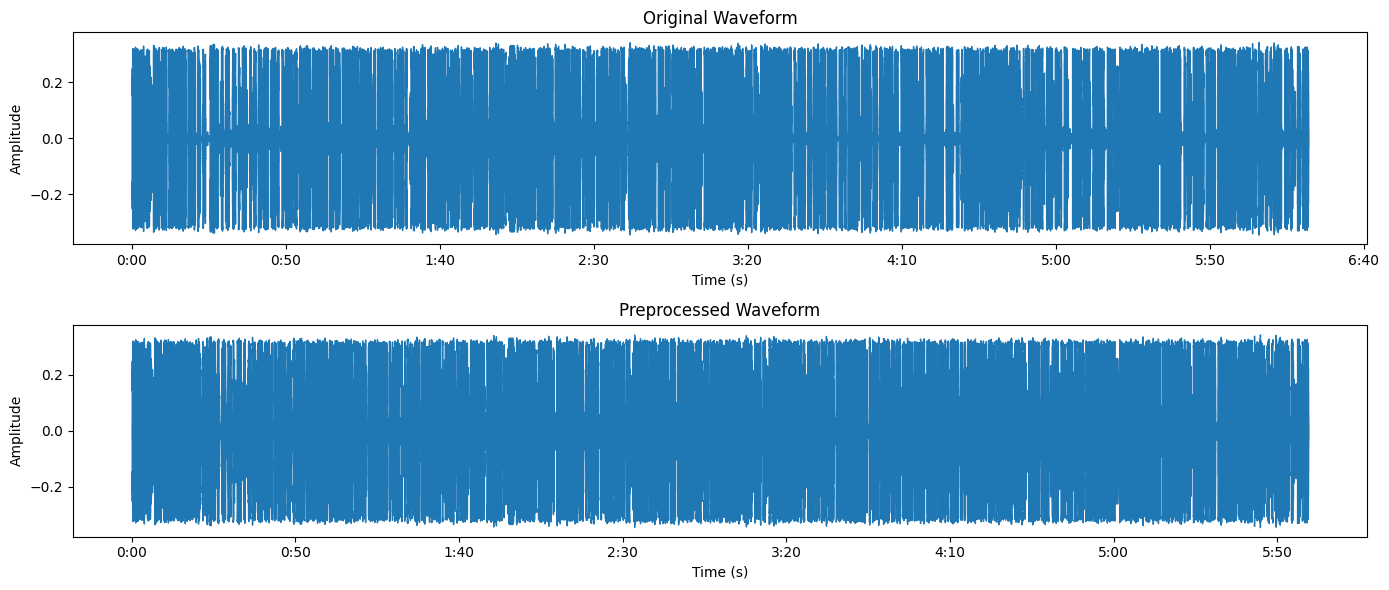

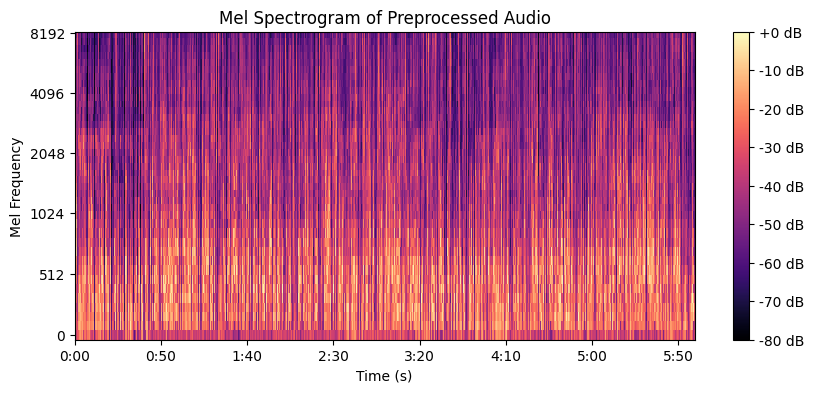

In [8]:
# Preprocess the audio
preprocessed_wav = Dpreprocess_wav(audio_file_path)

# Load original audio for comparison
original_wav, original_sr = librosa.load(audio_file_path, sr=None)

# Visualize Waveforms
plt.figure(figsize=(14, 6))

# Plot original waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(original_wav, sr=original_sr)
plt.title('Original Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot preprocessed waveform
plt.subplot(2, 1, 2)
librosa.display.waveshow(preprocessed_wav, sr=sampling_rate)
plt.title('Preprocessed Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Visualize Mel Spectrogram of Preprocessed Audio
mel_spectrogram = wav_to_mel_spectrogram(preprocessed_wav)

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram.T, ref=np.max), sr=sampling_rate, 
                         hop_length=int(sampling_rate * mel_window_step / 1000), 
                         x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram of Preprocessed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')
plt.show()

In [9]:
from sklearn.manifold import TSNE
import numpy as np

# Convert continuous embeddings to a numpy array
embeddings = np.array(cont_embeds)

# Use t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)


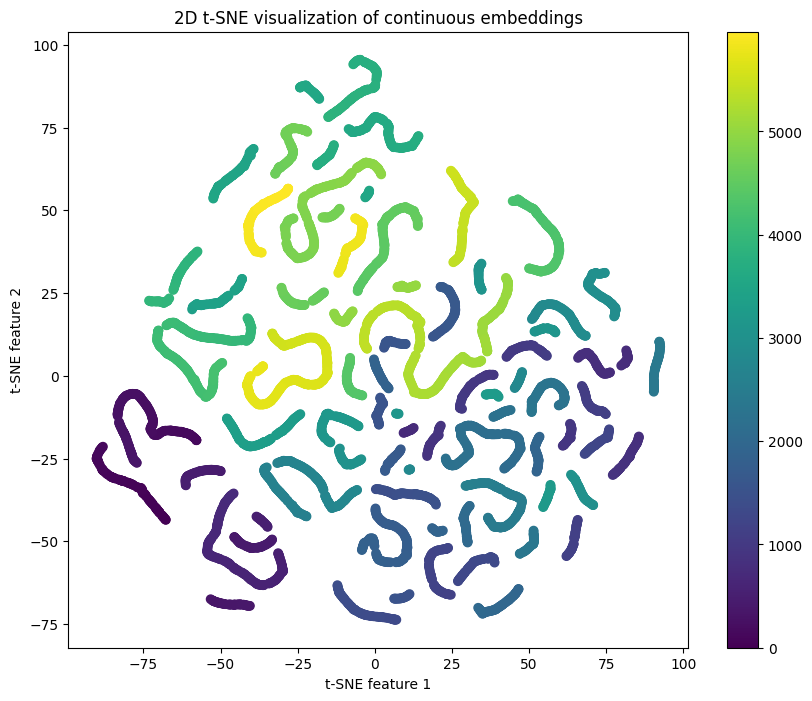

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=range(len(embeddings_2d)), cmap='viridis')
plt.colorbar()
plt.title("2D t-SNE visualization of continuous embeddings")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.show()

In [11]:
from spectralcluster import SpectralClusterer
from spectralcluster.utils import EigenGapType

clusterer = SpectralClusterer(
    min_clusters=2,
    max_clusters=10,
    eigengap_type=EigenGapType.Ratio
)
labels = clusterer.predict(cont_embeds)

In [12]:
import json
# import numpy as np

def create_labelling(labels, wav_splits):
    
    from Diarization import sampling_rate
    times = [((s.start + s.stop) / 2) / sampling_rate for s in wav_splits]
    labelling = []
    start_time = 0

    for i, time in enumerate(times):
        if i > 0 and labels[i] != labels[i - 1]:
            temp = {
                "start": float(start_time),
                "end": float(time),
                "speaker": int(labels[i - 1])
            }
            labelling.append(temp)
            start_time = time
        if i == len(times) - 1:
            temp = {
                "start": float(start_time),
                "end": float(time),
                "speaker": int(labels[i])
            }
            labelling.append(temp)

    return labelling

predicted_data = create_labelling(labels, wav_splits)

# Save the labelling to a JSON file
with open('./Output/Ourlabelling.json', 'w', encoding='utf-8') as f:
    json.dump(predicted_data, f, ensure_ascii=False, indent=4)

print("Labelling saved to labelling.json")

Labelling saved to labelling.json


In [26]:
import json

# Load the JSON files
file1_path = './Data/DataForDirization/audio_sample_20.json'
file2_path = './Output/Ourlabelling.json'

with open(file1_path, 'r', encoding='utf-8') as file:
    data1 = json.load(file)

with open(file2_path, 'r', encoding='utf-8') as file:
    data2 = json.load(file)

# Function to calculate overlap duration between two segments
def calculate_overlap(seg1, seg2):
    start = max(seg1['start'], seg2['start'])
    end = min(seg1['end'], seg2['end'])
    return max(0, end - start)

# Align segments and calculate DER
total_duration = 0
mismatched_duration = 0

for seg1 in data1:
    for seg2 in data2:
        overlap = calculate_overlap(seg1, seg2)
        if overlap > 0:
            total_duration += overlap
            if seg1['speaker'] != seg2['speaker']:
                mismatched_duration += overlap

# Calculate DER
der = mismatched_duration / total_duration if total_duration > 0 else 0

# Print results
print(f'Total Duration: {total_duration}')
print(f'Mismatched Duration: {mismatched_duration}')
print(f'Diarization Error Rate (DER): {der:.2%}')

Total Duration: 355.3172570597676
Mismatched Duration: 131.12778535273068
Diarization Error Rate (DER): 36.90%


In [29]:
from tensorflow.keras.models import load_model

# Load the diarization segments
diarization_path = './Output/Ourlabelling.json'
with open(diarization_path, 'r', encoding='utf-8') as file:
    diarization_segments = json.load(file)

# Load the audio file
audio_path = './Data/DataForDirization/audio_sample_20.wav'
audio, sr = librosa.load(audio_path, sr=None)


In [30]:
# Load model configuration from JSON
with open(modelA_Config_file_path, 'r') as json_file:
    model_config = json.load(json_file)

# Recreate model architecture\n",
ASR_model = keras.models.model_from_json(json.dumps(model_config))

#Load model weights
ASR_model.load_weights(modelA_file_path)

#Compile model with custom CTC loss function
ASR_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=CTCLoss)


# Function to predict text for an audio segment
def predict_text(segment_audio, model):
    # Preprocess the segment audio
    spectrogram = Apreprocess_audio(segment_audio)
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # Add the batch dimension
    
    # Predict the text
    prediction = model.predict(spectrogram)
    decoded_text = decode_batch_predictions(prediction)
    
    return decoded_text[0]


In [35]:
diarization_segments[0]

{'start': 0.0, 'end': 43.52, 'speaker': 0}

In [37]:
# Predict text for each diarization segment with a progress bar
predictions = []
for segment in tqdm(diarization_segments, desc="Processing segments"):
    start_sample = int(segment['start'] * sr)
    end_sample = int(segment['end'] * sr)
    segment_audio = audio[start_sample:end_sample]
    text = predict_text(segment_audio, ASR_model)
    predictions.append({
        'start': segment['start'],
        'end': segment['end'],
        'speaker': segment['speaker'],
        'text': text
    })

# Save the predictions to a JSON file
output_path = './Data/DataForDirization/audio_sample_20_with_predictions.json'
with open(output_path, 'w', encoding='utf-8') as file:
    json.dump(predictions, file, ensure_ascii=False, indent=4)

print(f"Predictions saved to {output_path}")

Processing segments:   0%|          | 0/67 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step


Processing segments:   1%|▏         | 1/67 [00:41<45:56, 41.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step


Processing segments:   3%|▎         | 2/67 [01:22<44:17, 40.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing segments:   4%|▍         | 3/67 [01:25<25:31, 23.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


Processing segments:   6%|▌         | 4/67 [01:31<17:38, 16.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Processing segments:   7%|▋         | 5/67 [01:31<11:12, 10.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Processing segments:   9%|▉         | 6/67 [01:32<07:23,  7.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Processing segments:  10%|█         | 7/67 [01:33<05:22,  5.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processing segments:  12%|█▏        | 8/67 [01:34<03:43,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing segments:  13%|█▎        | 9/67 [01:36<03:11,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


Processing segments:  15%|█▍        | 10/67 [01:57<08:14,  8.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing segments:  16%|█▋        | 11/67 [01:59<06:17,  6.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step


Processing segments:  18%|█▊        | 12/67 [02:37<14:50, 16.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


Processing segments:  19%|█▉        | 13/67 [02:48<13:14, 14.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


Processing segments:  21%|██        | 14/67 [03:02<12:54, 14.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing segments:  22%|██▏       | 15/67 [03:05<09:34, 11.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Processing segments:  24%|██▍       | 16/67 [03:10<07:50,  9.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing segments:  25%|██▌       | 17/67 [03:15<06:41,  8.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing segments:  27%|██▋       | 18/67 [03:19<05:23,  6.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


Processing segments:  28%|██▊       | 19/67 [03:35<07:39,  9.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing segments:  30%|██▉       | 20/67 [03:37<05:40,  7.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


Processing segments:  31%|███▏      | 21/67 [03:39<04:13,  5.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Processing segments:  33%|███▎      | 22/67 [03:40<03:11,  4.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing segments:  34%|███▍      | 23/67 [03:40<02:16,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


Processing segments:  36%|███▌      | 24/67 [03:41<01:41,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step


Processing segments:  37%|███▋      | 25/67 [03:42<01:21,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Processing segments:  39%|███▉      | 26/67 [03:42<01:03,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing segments:  40%|████      | 27/67 [03:43<00:46,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Processing segments:  42%|████▏     | 28/67 [03:43<00:37,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing segments:  43%|████▎     | 29/67 [03:47<01:05,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processing segments:  45%|████▍     | 30/67 [03:47<00:50,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing segments:  46%|████▋     | 31/67 [03:50<01:03,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


Processing segments:  48%|████▊     | 32/67 [03:51<00:58,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing segments:  49%|████▉     | 33/67 [03:54<01:02,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


Processing segments:  51%|█████     | 34/67 [03:55<00:51,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Processing segments:  52%|█████▏    | 35/67 [03:57<01:02,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Processing segments:  54%|█████▎    | 36/67 [03:58<00:45,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing segments:  55%|█████▌    | 37/67 [03:58<00:33,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Processing segments:  57%|█████▋    | 38/67 [03:59<00:26,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step


Processing segments:  58%|█████▊    | 39/67 [04:40<06:04, 13.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


Processing segments:  60%|█████▉    | 40/67 [04:47<05:03, 11.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Processing segments:  61%|██████    | 41/67 [05:08<06:06, 14.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Processing segments:  63%|██████▎   | 42/67 [05:08<04:08,  9.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


Processing segments:  64%|██████▍   | 43/67 [05:22<04:31, 11.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing segments:  66%|██████▌   | 44/67 [05:23<03:04,  8.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing segments:  67%|██████▋   | 45/67 [05:23<02:05,  5.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing segments:  69%|██████▊   | 46/67 [05:23<01:25,  4.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


Processing segments:  70%|███████   | 47/67 [05:24<01:00,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing segments:  72%|███████▏  | 48/67 [05:24<00:41,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Processing segments:  73%|███████▎  | 49/67 [05:25<00:29,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Processing segments:  75%|███████▍  | 50/67 [05:25<00:21,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing segments:  76%|███████▌  | 51/67 [05:25<00:15,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing segments:  78%|███████▊  | 52/67 [05:25<00:11,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing segments:  79%|███████▉  | 53/67 [05:31<00:29,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


Processing segments:  81%|████████  | 54/67 [05:51<01:40,  7.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Processing segments:  82%|████████▏ | 55/67 [05:53<01:09,  5.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing segments:  84%|████████▎ | 56/67 [05:57<00:58,  5.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processing segments:  85%|████████▌ | 57/67 [06:02<00:53,  5.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Processing segments:  87%|████████▋ | 58/67 [06:06<00:44,  4.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Processing segments:  88%|████████▊ | 59/67 [06:07<00:28,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


Processing segments:  90%|████████▉ | 60/67 [06:08<00:19,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Processing segments:  91%|█████████ | 61/67 [06:08<00:12,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


Processing segments:  93%|█████████▎| 62/67 [06:09<00:08,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Processing segments:  94%|█████████▍| 63/67 [06:09<00:05,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Processing segments:  96%|█████████▌| 64/67 [06:11<00:04,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


Processing segments:  97%|█████████▋| 65/67 [06:28<00:12,  6.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing segments:  99%|█████████▊| 66/67 [06:29<00:04,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Processing segments: 100%|██████████| 67/67 [06:34<00:00,  5.88s/it]

Predictions saved to ./Data/DataForDirization/audio_sample_20_with_predictions.json
